In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import RegularGridInterpolator
from pylab import rcParams
import seaborn as sns
import dill
import time
sns.set()
%matplotlib inline

## Gubser Coordinates (refs. arXiv:1012.1314, arXiv:1408.7048)
$\DeclareMathOperator{\sech}{sech}$
The Gubser spacetime coordinates $\hat{x}^{\mu} = (\rho, \theta, \phi, \eta)$ are related to the Milne coordinates $x^{\mu} = (\tau, r, \phi, \eta)$ via the following transformations:
$$\sinh(\rho) = -\frac{1-q^2\tau^2 + q^2r^2}{2q\tau}$$

$$\tan(\theta) = \frac{2qr}{1+q^2\tau^2 + q^2r^2}$$

These in turn imply:
$$q\tau = \frac{\sech(\rho)}{\cos(\theta) - \tanh(\rho)}$$

$$qr = \frac{\sin(\theta)}{\cos(\theta) - \tanh(\rho)}$$

To find the transformation law for momenta four-vector, we use
$$\hat{p}_{\mu} = \frac{\partial x_{\nu}}{\partial \hat{x}^{\mu}}p_{\nu}$$

In particular, 
$$\hat{p}_{\theta} = \frac{\partial \tau}{\partial \theta} p_{\tau} + \frac{\partial r}{\partial \theta} p_{r}$$

Since our Gubser solution $$f = f(\rho; \hat{p}_{\Omega}, \hat{p}_{\eta})$$,

some other useful relations include:

$$\hat{p}_{\eta} = p_{\eta}$$

$$\hat{p}_{\Omega}^2 = \hat{p}_{\theta}^2 + \frac{\hat{p}_{\phi}^2}{\sin^2(\theta)}$$

The solution to the RTA Boltzmann EQN with Gubser symmetry is given by the following integral equation:

$$f(\rho;\hat{p}^2_\Omega,\hat{p}_\varsigma)=
D(\rho,\rho_0) f_0(\rho_0;\hat p_\Omega^2,\hat{p}_\varsigma)
+\frac{1}{c}\int_{\rho_0}^\rho d\rho^{\prime}\,D(\rho,\rho^{\prime })\,
\hat T(\rho^{\prime })\, 
f_{\mathrm{eq}}(\rho^{\prime};\hat p_\Omega^2,\hat{p}_\varsigma)$$

where the Damping function is given by

$$D(\rho_2,\rho_1)=\exp\!\left(-\int_{\rho_1}^{\rho_2} d\rho''\,
\frac{\hat T(\rho'')}{c} \right)$$

where $c$ (a constant) is defined by $$c = 5\frac{\eta}{s} = \tau_R T$$. 


## Run the C++ code to generate the solution

In [3]:
#SET PARAMETERS HERE
#MAKE SURE THEY ARE CONSISTENT WITH THE PROFILE GENERATED BY WEYL RTA

#these parameters are for generating the solution in Gubser coords/momenta
n_rho = 1000 #number of steps in rho in weyl-RTA
c = 1000000. * 5. / (4. * np.pi) # 5 eta / s
rho0 = -9.99 # the initial Gubser time 
T_hat0 = 0.0002 # hatted temperature ^T at rho0 
n_grid_rho = 30 # number of points in rho to calculate 
rho_min = -9.99 #min value of rho to calculate
delta_rho = 0.3 #spacing 
n_grid_p_omega_hat = 30 #number of grid points in p_omega_hat
p_omega_hat_min = 0.0 #min value of p_omega_hat
delta_p_omega_hat = 0.1 #spacing in p_omega_hat
n_grid_p_eta_hat = 30 #number of points in p_eta_hat
p_eta_hat_min = 0.0 #min value of p_eta_hat
delta_p_eta_hat = 0.1 #spacing in p_eta_hat

#These parameters are used to generate the solution in Milne Coords 
n_r = 30
delta_r = 0.1
n_p_mag = 40
delta_p_mag = 0.025
n_phip = 20
n_vz = 10
tau0 = 0.5
q0 = 0.5

In [4]:
#first generate the input file
f = open("parameters.dat", "w")
f.write("n_rho "+str(n_rho)+"\n")
f.write("c "+str(c)+"\n")
f.write("rho0 "+str(rho0)+"\n")
f.write("T_hat0 "+str(T_hat0)+"\n")
f.write("n_grid_rho "+str(n_grid_rho)+"\n")
f.write("rho_min "+str(rho_min)+"\n")
f.write("delta_rho "+str(delta_rho)+"\n")
f.write("n_grid_p_omega_hat "+str(n_grid_p_omega_hat)+"\n")
f.write("p_omega_hat_min "+str(p_omega_hat_min)+"\n")
f.write("delta_p_omega_hat "+str(delta_p_omega_hat)+"\n")
f.write("n_grid_p_eta_hat "+str(n_grid_p_eta_hat)+"\n")
f.write("p_eta_hat_min "+str(p_eta_hat_min)+"\n")
f.write("delta_p_eta_hat "+str(delta_p_eta_hat)+"\n")
f.write("n_r "+str(n_r)+"\n")
f.write("delta_r "+str(delta_r)+"\n")
f.write("n_p_mag "+str(n_p_mag)+"\n")
f.write("delta_p_mag "+str(delta_p_mag)+"\n")
f.write("n_phip "+str(n_phip)+"\n")
f.write("n_vz "+str(n_vz)+"\n")
f.write("tau0 "+str(tau0)+"\n")
f.write("q0 "+str(q0))
f.close()

## Compile the c++ code 

In [5]:
!sh clean_make.sh

-- The C compiler identification is AppleClang 10.0.1.10010046
-- The CXX compiler identification is AppleClang 10.0.1.10010046
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found PkgConfig: /usr/local/bin/pkg-config (found version "0.29.2") 
-- Found GSL: /usr/local/Cellar/gsl/2.5/include (found version "2.5") 
-- Configuring done
-- Generating done
-- Build files have been written to: /Users/derek/

## Run the c++ code to generate the distribution function

In [6]:
!./integrate_gubser_RTA

####################### 
This code solves the distribution function f(tau, x, y; |p|, phi_p, v_z)... 
using the solution to the RTA Boltzmann EQN for Gubser symmetry. 
reading in parameters
allocating space 
Reading ^e profile from input/energy.dat 
generating f(rho, p_omega_hat, p_eta_hat) 
Done generating f(rho, p_omega_hat, p_eta_hat) 
took 2 seconds


In [111]:
#now let's plot the solution
f_profile = pd.read_csv('output/f_rho_pomegahat_petahat.dat', sep=' ', 
                            header=None, names=['rho', 'p_omega_hat', 'p_eta_hat', 'f'])
#sns.heatmap(f_profile, annot=True)

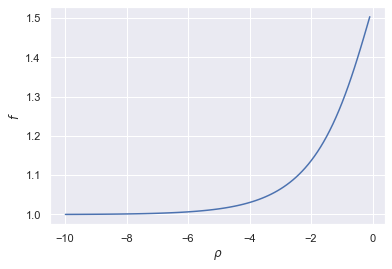

In [112]:
f_cut = f_profile[f_profile.p_omega_hat == 0.]
f_cut = f_cut[f_cut.p_eta_hat == 0.]
plt.plot(f_cut['rho'], f_cut['f'])
plt.xlabel(r'$\rho$')
plt.ylabel(r'$f$')
plt.show()

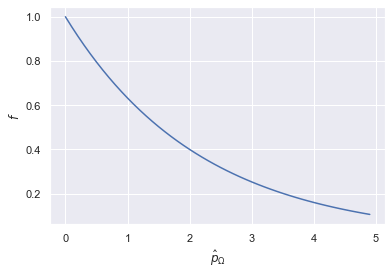

In [113]:
f_cut = f_profile[f_profile.rho == -9.99]
f_cut = f_cut[f_cut.p_eta_hat == 0.]
plt.plot(f_cut['p_omega_hat'], f_cut['f'])
plt.xlabel(r'$\hat{p}_{\Omega}$')
plt.ylabel(r'$f$')
plt.show()

## We can plot the solution in Milne coordinates / momenta

In [114]:
f_profile_milne = pd.read_csv('output/f_r_p_phip_vz.dat', sep=' ', 
                            header=None, names=['r', 'p', 'phip', 'vz', 'f'])
#f_profile_milne

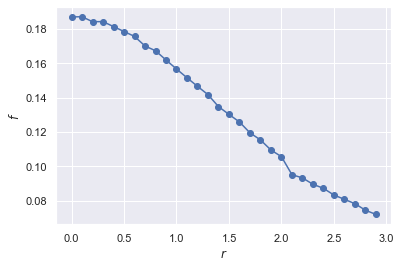

In [115]:
f_cut = f_profile_milne[f_profile_milne.phip == 0.]
f_cut = f_cut[f_cut.vz == 0.1]
f_cut = f_cut[f_cut.p == 0.1]
plt.plot(f_cut['r'], f_cut['f'], marker='o')
plt.xlabel(r'$r$')
plt.ylabel(r'$f$')
plt.show()

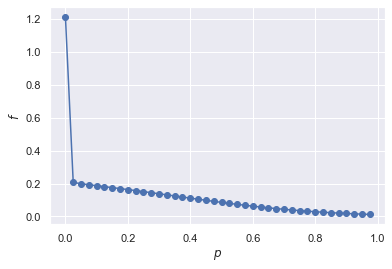

In [116]:
f_cut = f_profile_milne[f_profile_milne.phip == 0.]
f_cut = f_cut[f_cut.vz == 0.1]
f_cut = f_cut[f_cut.r == 0.0]
plt.plot(f_cut['p'], f_cut['f'], marker='o')
plt.xlabel(r'$p$')
plt.ylabel(r'$f$')
plt.show()